In [1]:
import numpy as np
# import cupy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
from time import time

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
y = y.astype(np.uint8)

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [6]:
enc.fit(y[:,np.newaxis])

OneHotEncoder()

In [7]:
Y = enc.transform(y[:,np.newaxis]).toarray()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [9]:
X_train = X_train / 255
X_test = X_test / 255

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

## Cost Function with L2 Regularization
- 기존 cost값에 regularization값을 추가한다.
- L2 regularization을 사용할 것이므로, $\frac{\lambda}{2N}\Vert w \Vert_2^2$를 추가해준다

In [12]:
def compute_cost(X, T, W, reg_lam):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    W_N = np.size(W, 1)

    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1))
    cost += -(1/(2*N)) * reg_lam * np.ones((1,W_N)) @ (W.T @ W) @ np.ones((W_N,1))
    return cost

In [13]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

## gradient 함수에 regularization term 추가
- L2 norm의 미분값인 $\lambda w$를 gradient descent함수에 추가해준다

In [14]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, reg_lam):
    iterations += 1
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch)+ reg_lam * W)
        # cost_history[i] = compute_cost(X_batch, T_batch, W, reg_lam)
        # cost_history[i] = compute_cost(X_batch, T_batch, W, reg_lam)[0]
        
        if i % 10000 == 0:
            running_cost = compute_cost(X_batch, T_batch, W, reg_lam)
            print(f"Running Cost is: {running_cost[0].item():.4f}")
            # print(f"Running Cost is: {cost_history[i][0]:.4f}")
            # print(f"Running Cost is: {cost_history[i].item():.4f}")
        

    return (cost_history, W)

In [16]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train)) ## dummy input 넣는부분
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)

iterations = 50000
learning_rate = 0.002
score_history = list()
reg_lams = [0]
reg_lams = np.append(reg_lams, 0.2 * np.random.rand(100))
# reg_lams = 0.2*np.random.rand(100)
reg_lams.sort()
print(reg_lams)

for reg_lam in reg_lams:
    start = time()
    W = np.zeros((M,K))
    
    print(f"<--- Using Lambda {reg_lam} --->")
#     initial_cost = compute_cost(X, T, W, reg_lam)
    
#     print(f"Initial Cost is: {initial_cost[0][0]:.4f}")

    (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, reg_lam)
#     (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 256, reg_lam)
    print(f"Training Time : {time()-start:.4f} sec")
    ## Accuracy
    X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
    T_ = y_test
    y_pred = predict(X_, W_optimal)
    score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))
    
    print(f"Accuracy is: {score:.3f} with lambda = {reg_lam} \n")
    score_history.append(score)

[0.         0.00027288 0.00053789 0.00360704 0.00604315 0.00642355
 0.00775846 0.00784046 0.00826274 0.00882711 0.00931801 0.01092245
 0.0109437  0.01146575 0.0145583  0.01550073 0.01869365 0.01974525
 0.02295134 0.02541228 0.02717794 0.02784669 0.02885514 0.03026774
 0.03098847 0.03354669 0.03390518 0.03539919 0.03608472 0.03613004
 0.04092804 0.04180787 0.0420516  0.04207217 0.04390548 0.04640574
 0.04959105 0.05202504 0.05327247 0.05331671 0.05422645 0.05513867
 0.05619881 0.05656314 0.06361945 0.06617735 0.06799758 0.06946507
 0.0701986  0.07443659 0.07499778 0.07556475 0.07852998 0.07896543
 0.07954039 0.08038541 0.08161447 0.08788781 0.09271732 0.09440328
 0.09485852 0.09531802 0.09850027 0.10028547 0.10129405 0.10312236
 0.10900223 0.11082347 0.11272431 0.11650064 0.1169432  0.11762229
 0.12027958 0.12390671 0.12410279 0.1264001  0.13196738 0.13239325
 0.14036033 0.14662699 0.14848068 0.14920917 0.14976346 0.15073366
 0.15313663 0.15998872 0.16313292 0.16494417 0.17084492 0.1718

Running Cost is: 0.5652
Running Cost is: 0.4109
Running Cost is: 0.5423
Running Cost is: 0.3218
Running Cost is: 0.4531
Training Time : 6.7141 sec
Accuracy is: 0.908 with lambda = 0.03390517903515997 

<--- Using Lambda 0.03539919397785154 --->
Running Cost is: 2.2981
Running Cost is: 0.4124
Running Cost is: 0.3442
Running Cost is: 0.2640
Running Cost is: 0.4366
Running Cost is: 0.3343
Training Time : 6.7630 sec
Accuracy is: 0.909 with lambda = 0.03539919397785154 

<--- Using Lambda 0.0360847177352309 --->
Running Cost is: 2.2980
Running Cost is: 0.5811
Running Cost is: 0.4063
Running Cost is: 0.4324
Running Cost is: 0.4633
Running Cost is: 0.1888
Training Time : 6.6137 sec
Accuracy is: 0.906 with lambda = 0.0360847177352309 

<--- Using Lambda 0.036130042017505914 --->
Running Cost is: 2.2982
Running Cost is: 0.4555
Running Cost is: 0.4469
Running Cost is: 0.2705
Running Cost is: 0.3868
Running Cost is: 0.4466
Training Time : 6.6847 sec
Accuracy is: 0.909 with lambda = 0.036130042017

Running Cost is: 2.2979
Running Cost is: 0.5647
Running Cost is: 0.4595
Running Cost is: 0.3424
Running Cost is: 0.3573
Running Cost is: 0.4504
Training Time : 6.7280 sec
Accuracy is: 0.906 with lambda = 0.0878878084206086 

<--- Using Lambda 0.09271732096890005 --->
Running Cost is: 2.2982
Running Cost is: 0.4467
Running Cost is: 0.6039
Running Cost is: 0.3368
Running Cost is: 0.3761
Running Cost is: 0.4533
Training Time : 6.6812 sec
Accuracy is: 0.906 with lambda = 0.09271732096890005 

<--- Using Lambda 0.09440327812292695 --->
Running Cost is: 2.2971
Running Cost is: 0.5451
Running Cost is: 0.4115
Running Cost is: 0.3923
Running Cost is: 0.3189
Running Cost is: 0.3635
Training Time : 6.7515 sec
Accuracy is: 0.909 with lambda = 0.09440327812292695 

<--- Using Lambda 0.09485851653094993 --->
Running Cost is: 2.2989
Running Cost is: 0.6749
Running Cost is: 0.4061
Running Cost is: 0.3555
Running Cost is: 0.3940
Running Cost is: 0.4012
Training Time : 6.7859 sec
Accuracy is: 0.906 with

Running Cost is: 2.2978
Running Cost is: 0.4812
Running Cost is: 0.3606
Running Cost is: 0.3763
Running Cost is: 0.4863
Running Cost is: 0.3364
Training Time : 6.7360 sec
Accuracy is: 0.907 with lambda = 0.17084492406806892 

<--- Using Lambda 0.17185581333660188 --->
Running Cost is: 2.2972
Running Cost is: 0.3392
Running Cost is: 0.4523
Running Cost is: 0.3892
Running Cost is: 0.2939
Running Cost is: 0.3666
Training Time : 6.6343 sec
Accuracy is: 0.904 with lambda = 0.17185581333660188 

<--- Using Lambda 0.17488933958119723 --->
Running Cost is: 2.2975
Running Cost is: 0.5021
Running Cost is: 0.3915
Running Cost is: 0.3119
Running Cost is: 0.3380
Running Cost is: 0.2588
Training Time : 6.7862 sec
Accuracy is: 0.908 with lambda = 0.17488933958119723 

<--- Using Lambda 0.17651873895643602 --->
Running Cost is: 2.2990
Running Cost is: 0.4535
Running Cost is: 0.4031
Running Cost is: 0.2983
Running Cost is: 0.5782
Running Cost is: 0.3218
Training Time : 6.7669 sec
Accuracy is: 0.905 wit

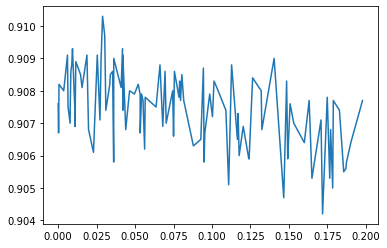

In [17]:
plt.plot(reg_lams, score_history)

## lambda 값
- 위 결과를 볼때, 많이 noisy하긴 하지만, 대략 0.025근처의 값에서 최대가 됨을 알 수 있다. 따라서 0.025로 설정한다